In [1]:
from folktables import ACSDataSource, ACSEmployment, ACSIncome
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.gaussian_process.kernels import RBF
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random

from tqdm import tqdm
import scipy.stats
import torch
import crypten


# local libraries
import sys

crypten.init()
sys.path.append("..")
from folktables_exp import metrics as mt
from sklearn.metrics import accuracy_score, roc_auc_score

In [2]:
data_dict = {}

In [3]:
year = "2014"
STATES = ["CA", "OH", "DE", "AK", "HI", "SD", "PA", "MI", "GA", "MS"]
for state in STATES:
    data_dict[state] = {}
    data_source = ACSDataSource(survey_year=year, horizon="1-Year", survey="person")
    acs_data = data_source.get_data(states=[state], download=True)
    data_dict[state][year] = {}
    features, label, group = ACSIncome.df_to_numpy(acs_data)
    data_dict[state][year]["x"] = features
    data_dict[state][year]["y"] = label
    data_dict[state][year]["g"] = np.vectorize(mt.race_grouping.get)(group)

## Creating State Results with CA as the reference state 

### Trained models with CA dataset and evaluated on features from other states


In [4]:
results = []
n_runs = 1
clf_list = ["LR", "GB", "XGB"]
for clf in clf_list:
    for i in range(n_runs):
        ref_state = "CA"
        X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
            data_dict[ref_state][year]["x"],
            data_dict[ref_state][year]["y"],
            data_dict[ref_state][year]["g"],
            test_size=0.2,
            random_state=i,
        )

        model = mt.model_choice(clf, X_train, y_train)

        model.fit(X_train, y_train)

        y_hat = model.predict(X_test)
        corr = y_hat == y_test
        g_acc_dict = mt.group_accuracy(corr, group_test)
        g_auc_dict = mt.group_auc(y_test, model.predict_proba(X_test)[:, 1], group_test)

        results.append(
            {
                "year": year,
                "test_Accuracy": metrics.accuracy_score(y_hat, y_test),
                "disp_Accuracy": max(g_acc_dict.values()) - min(g_acc_dict.values()),
                "worst_g_Accuracy": min(g_acc_dict.values()),
                "test_AUC": metrics.roc_auc_score(
                    y_test, model.predict_proba(X_test)[:, 1]
                ),
                "disp_AUC": max(g_auc_dict.values()) - min(g_auc_dict.values()),
                "worst_g_AUC": min(g_auc_dict.values()),
                "size": len(y_train),
                "run": i,
                "state": ref_state,
                "clf": clf,
            }
        )

        for state in STATES:
            if state != ref_state:
                (
                    X_train,
                    X_test,
                    y_train,
                    y_test,
                    group_train,
                    group_test,
                ) = train_test_split(
                    data_dict[state][year]["x"],
                    data_dict[state][year]["y"],
                    data_dict[state][year]["g"],
                    test_size=0.4,
                    random_state=i,
                )
                y_hat = model.predict(X_test)
                corr = y_hat == y_test
                g_acc_dict = mt.group_accuracy(corr, group_test)
                g_auc_dict = mt.group_auc(
                    y_test, model.predict_proba(X_test)[:, 1], group_test
                )

                results.append(
                    {
                        "year": year,
                        "test_Accuracy": metrics.accuracy_score(y_hat, y_test),
                        "disp_Accuracy": max(g_acc_dict.values())
                        - min(g_acc_dict.values()),
                        "worst_g_Accuracy": min(g_acc_dict.values()),
                        "test_AUC": metrics.roc_auc_score(
                            y_test, model.predict_proba(X_test)[:, 1]
                        ),
                        "disp_AUC": max(g_auc_dict.values()) - min(g_auc_dict.values()),
                        "worst_g_AUC": min(g_auc_dict.values()),
                        "size": len(y_train),
                        "run": i,
                        "state": state,
                        "clf": clf,
                    }
                )

In [5]:
# os.makedirs("../results", exist_ok=True)
results_df = pd.DataFrame(results)
results_df.to_csv(f"../results/states_results.csv")

# Encrypted empirical KL

### Part 1: Evaluate KL via empirical kernel density estimation between source and target distributiosn (States)

In [6]:
results_df = pd.read_csv("../results/states_results.csv")  

In [7]:
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
import scipy.special as sp
from sklearn.model_selection import GridSearchCV

In [8]:
# run state classifier
state_results = results_df[["test_Accuracy", "state", "clf"]]
states_mean = state_results.groupby(["state", "clf"]).mean()

## Crypten KL on sample data

In [9]:
incl = 1000
year = '2014'
x1, x2 = data_dict['CA'][year]["x"][:incl], data_dict['OH'][year]["x"][:incl]
cx, model1 = mt.init_density_scale(x1)
model2 = mt.init_density(x2, cx)
mt.entropy_input(x1, model1, model2, cx) ## reference KL 

best bandwidth: 0.33598182862837817


np.float64(0.33744481002347093)

In [10]:
p = torch.tensor(np.exp(model1.score_samples(cx.transform(x1))))  + 1e-6
q = torch.tensor(np.exp(model2.score_samples(cx.transform(x1))))  + 1e-6

In [11]:
p/=p.sum() #normalize
q/=q.sum()

In [12]:
(p * (torch.log(p/q))).sum() ## KL without library 

tensor(0.3374, dtype=torch.float64)

In [13]:
# encrypt logprobs 
ep_log = crypten.cryptensor(p.log()) 
eq_log = crypten.cryptensor(q.log())

**Attempt 1: Using unstable KL formula doesn't work**

In [17]:
eq = crypten.cryptensor(q)
(ep * ((ep/eq).log())).sum().get_plain_text()

tensor(0.1220)

**Attempt 2: KL using encrypted logprobs works, but doesn't give the most accurate score**

In [14]:
(ep_log.exp() * (ep_log - eq_log)).sum().get_plain_text()

tensor(0.2909)

**Attempt 3: I encrypt the probs and logprobs seperately to get a more accurate result**

In [15]:
ep = crypten.cryptensor(p) 

In [16]:
(ep * (ep_log - eq_log)).sum().get_plain_text()

tensor(0.3296)

In [18]:
## takes in encryted logprob tensors, returns KL  
def encrypted_entropy(p, q):
    return (p.exp() * (p - q)).sum()

In [19]:
def get_encrypted_log_probs(estimator, cx, x):
    example_probs = torch.tensor(estimator.score_samples(cx.transform(x))).exp() + 1e-6
    return crypten.cryptensor((example_probs / example_probs.sum()).log())

In [20]:
ref_state = "CA"
samples = 3000


joint_xy_ref = np.concatenate(
    (data_dict[ref_state][year]["x"], data_dict[ref_state][year]["y"].reshape(-1, 1)),
    axis=1,
)

incl = np.asarray(random.sample(range(len(joint_xy_ref)), samples))

cx, pkdex = mt.init_density_scale(data_dict[ref_state][year]["x"][incl])
cxy, pkdexy = mt.init_density_scale(joint_xy_ref[incl])

num_iter = 1
for i in range(num_iter):
    kl_df = pd.DataFrame()
    for state in STATES:
        print(state)
        if state != ref_state:
            joint_xy = np.concatenate(
                (
                    data_dict[state][year]["x"],
                    data_dict[state][year]["y"].reshape(-1, 1),
                ),
                axis=1,
            )

            diff_df = states_mean.loc[ref_state] - states_mean.loc[state]

            # sample
            incl = np.asarray(random.sample(range(len(joint_xy)), samples))
            qkdexy = mt.init_density(joint_xy[incl], cxy)
            qkdex = mt.init_density(data_dict[state][year]["x"][incl], cx)
            p = get_encrypted_log_probs(pkdex, cx, data_dict[ref_state][year]["x"][incl])
            q = get_encrypted_log_probs(qkdex, cx, data_dict[ref_state][year]["x"][incl])
            diff_df["KL_x"] = mt.entropy_input(
                data_dict[ref_state][year]["x"][incl], pkdex, qkdex, cx
            )
            diff_df["e_KL_x"] = encrypted_entropy(p, q).get_plain_text().item()
            diff_df["KL_xy"] = mt.entropy_input(joint_xy_ref[incl], pkdexy, qkdexy, cxy)
            p = get_encrypted_log_probs(pkdexy, cxy, joint_xy_ref[incl])
            q = get_encrypted_log_probs(qkdexy, cxy, joint_xy_ref[incl])
            diff_df["e_KL_xy"] = encrypted_entropy(p, q).get_plain_text().item()
            diff_df["state"] = state
            diff_df["iter"] = i
            kl_df = pd.concat((kl_df, diff_df))
#kl_df.to_csv("../results/kl_shift.csv")

best bandwidth: 0.33598182862837817
best bandwidth: 0.33598182862837817
CA
OH
DE
AK
HI
SD
PA
MI
GA
MS


In [21]:
kl_df

,test_Accuracy,KL_x,e_KL_x,KL_xy,e_KL_xy,state,iter
clf,,,,,,,
GB,0.013361,0.174872,0.128265,0.211194,0.161407,OH,0
LR,0.001819,0.174872,0.128265,0.211194,0.161407,OH,0
XGB,0.027894,0.174872,0.128265,0.211194,0.161407,OH,0
GB,0.041076,0.120645,0.088638,0.132600,0.100876,DE,0
LR,0.033153,0.120645,0.088638,0.132600,0.100876,DE,0
XGB,0.044329,0.120645,0.088638,0.132600,0.100876,DE,0
GB,0.068041,0.153545,0.116867,0.179022,0.140778,AK,0
LR,0.070199,0.153545,0.116867,0.179022,0.140778,AK,0
XGB,0.068689,0.153545,0.116867,0.179022,0.140778,AK,0


0.44418948099606803 0.020278841561959287


Text(0.5, 0.98, 'KL divergence between KL(p(CA train) || p(State_test)) with respect to accuracy drop')

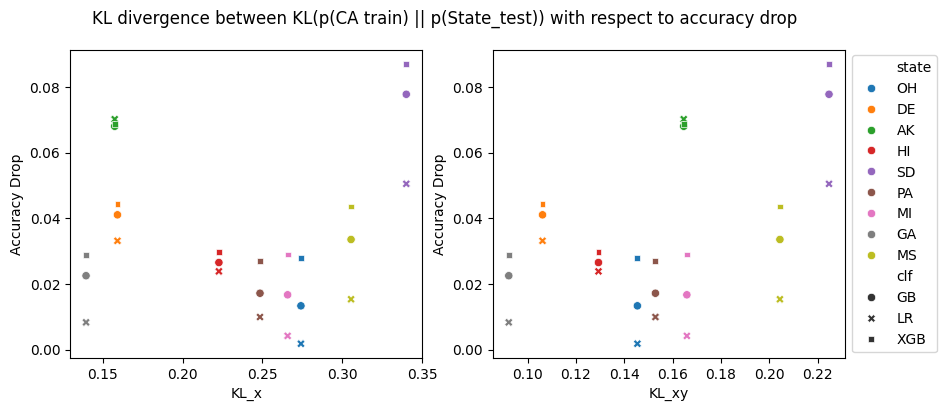

In [232]:
# l_df = pd.read_csv("../results/kl_shift.csv")
# kl_df = kl_df.reset_index()
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.scatterplot(
    data=kl_df,
    x="KL_x",
    y="test_Accuracy",
    hue="state",
    style="clf",
    ax=axes[0],
    legend=False,
)
axes[0].set_ylabel("Accuracy Drop")
coeff, p = scipy.stats.pearsonr(kl_df["test_Accuracy"], kl_df["KL_xy"])
print(coeff, p)
sns.scatterplot(
    data=kl_df,
    x="KL_xy",
    y="test_Accuracy",
    style="clf",
    hue="state",
    ax=axes[1],
)
axes[1].set_ylabel("Accuracy Drop")
axes[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.suptitle(
    "KL divergence between KL(p(CA train) || p(State_test)) with respect to accuracy drop"
)

0.44418948099606803 0.020278841561959287


Text(0.5, 0.98, 'Encrypted KL divergence between KL(p(CA train) || p(State_test)) with respect to accuracy drop')

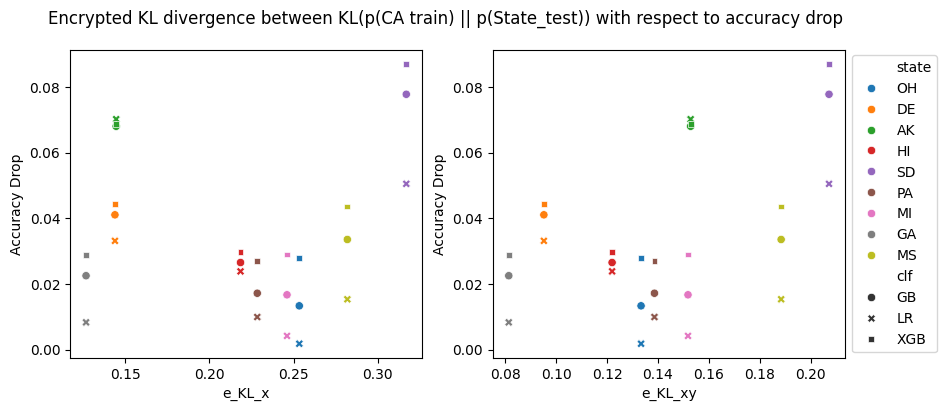

In [233]:
# l_df = pd.read_csv("../results/kl_shift.csv")
# kl_df = kl_df.reset_index()
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.scatterplot(
    data=kl_df,
    x="e_KL_x",
    y="test_Accuracy",
    hue="state",
    style="clf",
    ax=axes[0],
    legend=False,
)
axes[0].set_ylabel("Accuracy Drop")
coeff, p = scipy.stats.pearsonr(kl_df["test_Accuracy"], kl_df["KL_xy"])
print(coeff, p)
sns.scatterplot(
    data=kl_df,
    x="e_KL_xy",
    y="test_Accuracy",
    style="clf",
    hue="state",
    ax=axes[1],
)
axes[1].set_ylabel("Accuracy Drop")
axes[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.suptitle(
    "Encrypted KL divergence between KL(p(CA train) || p(State_test)) with respect to accuracy drop"
)

# Evaluate KL on joint state and ref state data 
